### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

### Reading all raw data

In [2]:
train = pd.read_csv(r'C:\Users\Archana\Desktop\test & train\project 6\train.csv')
test = pd.read_csv(r'C:\Users\Archana\Desktop\test & train\project 6\test_share.csv')
med = pd.read_csv(r'C:\Users\Archana\Desktop\test & train\project 6\medical_history.csv')
demo = pd.read_csv(r'C:\Users\Archana\Desktop\test & train\project 6\demographic_details.csv')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# Convert PatientId from Float to Integer
train['PatientId'] = train['PatientId'].astype('int64')
test['PatientId'] = test['PatientId'].astype('int64')
med['PatientId'] = med['PatientId'].astype('int64')
demo['PatientId'] = demo['PatientId'].astype('int64')

In [5]:
train.shape, test.shape, med.shape, demo.shape

((99490, 6), (10854, 5), (62299, 5), (62299, 5))

In [6]:
med.head(), demo.head()

(         PatientId  Hipertension  Diabetes  Alcoholism  Handcap
 0   29872499824296             1         0           0        0
 1  558997776694438             0         0           0        0
 2    4262962299951             0         0           0        0
 3     867951213174             0         0           0        0
 4    8841186448183             1         1           0        0,
          PatientId Gender  Age      Neighbourhood  Scholarship
 0   29872499824296      F   62    JARDIM DA PENHA            0
 1  558997776694438      M   56    JARDIM DA PENHA            0
 2    4262962299951      F   62      MATA DA PRAIA            0
 3     867951213174      F    8  PONTAL DE CAMBURI            0
 4    8841186448183      F   56    JARDIM DA PENHA            0)

In [7]:
#merging medical history & demographic details 
med_demo = pd.merge(med, demo, how ='outer', on ='PatientId')

In [8]:
med_demo.head()

,PatientId,Hipertension,Diabetes,Alcoholism,Handcap,Gender,Age,Neighbourhood,Scholarship
0,29872499824296,1,0,0,0,F,62,JARDIM DA PENHA,0
1,558997776694438,0,0,0,0,M,56,JARDIM DA PENHA,0
2,4262962299951,0,0,0,0,F,62,MATA DA PRAIA,0
3,867951213174,0,0,0,0,F,8,PONTAL DE CAMBURI,0
4,8841186448183,1,1,0,0,F,56,JARDIM DA PENHA,0


In [9]:
med_demo.shape

(62299, 9)

In [10]:
#merging above created data with train & test dataset
train_md = pd.merge(train, med_demo, how ='inner', on ='PatientId')
test_md = pd.merge(test, med_demo, how ='inner', on ='PatientId')

In [11]:
train_md.shape, test_md.shape

((99490, 14), (10854, 13))

In [12]:
train_md.isnull().sum(), test_md.isnull().sum()

(PatientId         0
 AppointmentID     0
 ScheduledDay      0
 AppointmentDay    0
 SMS_received      0
 No-show           0
 Hipertension      0
 Diabetes          0
 Alcoholism        0
 Handcap           0
 Gender            0
 Age               0
 Neighbourhood     0
 Scholarship       0
 dtype: int64,
 PatientId         0
 AppointmentID     0
 ScheduledDay      0
 AppointmentDay    0
 SMS_received      0
 Hipertension      0
 Diabetes          0
 Alcoholism        0
 Handcap           0
 Gender            0
 Age               0
 Neighbourhood     0
 Scholarship       0
 dtype: int64)

In [13]:
train_md.info(), test_md.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99490 entries, 0 to 99489
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PatientId       99490 non-null  int64 
 1   AppointmentID   99490 non-null  int64 
 2   ScheduledDay    99490 non-null  object
 3   AppointmentDay  99490 non-null  object
 4   SMS_received    99490 non-null  int64 
 5   No-show         99490 non-null  object
 6   Hipertension    99490 non-null  int64 
 7   Diabetes        99490 non-null  int64 
 8   Alcoholism      99490 non-null  int64 
 9   Handcap         99490 non-null  int64 
 10  Gender          99490 non-null  object
 11  Age             99490 non-null  int64 
 12  Neighbourhood   99490 non-null  object
 13  Scholarship     99490 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 11.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10854 entries, 0 to 10853
Data columns (total 13 columns):
 #   Column          Non-Nu

(None, None)

In [14]:
# rename the columns
train_md = train_md.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'No-show': 'No_Show'})
test_md = test_md.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap'})

In [15]:
# Adding new columns in both dataframe
train_md['Data'] = 'train'
test_md['Data'] = 'test'

In [16]:
# moving No_Show column to end
column_to_move = train_md.pop("No_Show")

# insert column with insert(location, column_name, column_value)
train_md.insert(14, "No_Show", column_to_move)

# different method
#df1 = df.pop('No_Show') # remove column No_Show and store it in df1
#df['No_Show']=df1 # add No_Show series as a 'new' column.

In [17]:
train_md.columns, test_md.columns

(Index(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay',
        'SMS_received', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap',
        'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Data', 'No_Show'],
       dtype='object'),
 Index(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay',
        'SMS_received', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap',
        'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Data'],
       dtype='object'))

In [18]:
#To make both dataframe in same order
#test_md = test_md[train_md.columns]

In [19]:
train_md.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,SMS_received,Hypertension,Diabetes,Alcoholism,Handicap,Gender,Age,Neighbourhood,Scholarship,Data,No_Show
0,29872499824296,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,0,1,0,0,0,F,62,JARDIM DA PENHA,0,train,No
1,29872499824296,5639907,2016-04-29T09:47:47Z,2016-04-29T00:00:00Z,0,1,0,0,0,F,62,JARDIM DA PENHA,0,train,No
2,558997776694438,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,0,0,0,0,0,M,56,JARDIM DA PENHA,0,train,No
3,558997776694438,5642211,2016-04-29T15:20:47Z,2016-04-29T00:00:00Z,0,0,0,0,0,M,56,JARDIM DA PENHA,0,train,No
4,867951213174,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,0,0,0,0,0,F,8,PONTAL DE CAMBURI,0,train,No


In [20]:
test_md.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,SMS_received,Hypertension,Diabetes,Alcoholism,Handicap,Gender,Age,Neighbourhood,Scholarship,Data
0,7223289184215,5640433,2016-04-29T10:43:14Z,2016-04-29T00:00:00Z,0,0,0,0,0,F,46,DA PENHA,0,test
1,863229818887631,5616091,2016-04-25T13:29:16Z,2016-04-29T00:00:00Z,1,0,0,0,0,M,13,CONQUISTA,0,test
2,443858731994526,5637909,2016-04-29T07:30:31Z,2016-04-29T00:00:00Z,0,0,0,0,0,M,6,CONQUISTA,0,test
3,443858731994526,5676948,2016-05-09T17:01:17Z,2016-05-10T00:00:00Z,0,0,0,0,0,M,6,CONQUISTA,0,test
4,41799315536436,5638018,2016-04-29T07:37:45Z,2016-04-29T00:00:00Z,0,0,0,0,0,M,2,NOVA PALESTINA,0,test


In [21]:
# Concat train and test data-
df = pd.concat([train_md,test_md], axis=0)

In [22]:
df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,SMS_received,Hypertension,Diabetes,Alcoholism,Handicap,Gender,Age,Neighbourhood,Scholarship,Data,No_Show
0,29872499824296,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,0,1,0,0,0,F,62,JARDIM DA PENHA,0,train,No
1,29872499824296,5639907,2016-04-29T09:47:47Z,2016-04-29T00:00:00Z,0,1,0,0,0,F,62,JARDIM DA PENHA,0,train,No
2,558997776694438,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,0,0,0,0,0,M,56,JARDIM DA PENHA,0,train,No
3,558997776694438,5642211,2016-04-29T15:20:47Z,2016-04-29T00:00:00Z,0,0,0,0,0,M,56,JARDIM DA PENHA,0,train,No
4,867951213174,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,0,0,0,0,0,F,8,PONTAL DE CAMBURI,0,train,No


In [23]:
df.isnull().sum()

PatientId             0
AppointmentID         0
ScheduledDay          0
AppointmentDay        0
SMS_received          0
Hypertension          0
Diabetes              0
Alcoholism            0
Handicap              0
Gender                0
Age                   0
Neighbourhood         0
Scholarship           0
Data                  0
No_Show           10854
dtype: int64

In [24]:
# converting object type to datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')

df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110344 entries, 0 to 10853
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110344 non-null  int64         
 1   AppointmentID   110344 non-null  int64         
 2   ScheduledDay    110344 non-null  datetime64[ns]
 3   AppointmentDay  110344 non-null  datetime64[ns]
 4   SMS_received    110344 non-null  int64         
 5   Hypertension    110344 non-null  int64         
 6   Diabetes        110344 non-null  int64         
 7   Alcoholism      110344 non-null  int64         
 8   Handicap        110344 non-null  int64         
 9   Gender          110344 non-null  object        
 10  Age             110344 non-null  int64         
 11  Neighbourhood   110344 non-null  object        
 12  Scholarship     110344 non-null  int64         
 13  Data            110344 non-null  object        
 14  No_Show         99490 non-null   obje

### No_Show

In [26]:
df['No_Show'] = np.where(df['No_Show'] == 'Yes', 1, 0)
df['No_Show'].unique()

array([0, 1])

### Handicap

In [27]:
df['Handicap'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [28]:
# change all the Handicap set above 0 as 1
df['Handicap'] = np.where(df['Handicap'] >= 1, 1, 0)

# different method
# train_md.loc[train_md.Handicap > 0, 'Handicap'] = 1

In [ ]:
df['Handicap'].unique()

### Gender

In [29]:
df['Gender'] = np.where(df['Gender'] == "F", 1, 0)

In [ ]:
df['Gender'].unique()

### Waiting_Day

In [30]:
# Adding a column which gives total waiting days
df['Waiting_Day'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

In [ ]:
# drop unwanted columns
df.drop(['AppointmentDay','ScheduledDay'],axis=1,inplace=True)

In [ ]:
df['Waiting_Day'].unique()

In [31]:
# Waiting_Day cannot be less than 0
df[(df['Waiting_Day'] < 0)].Waiting_Day.value_counts()

-1    4
-6    1
Name: Waiting_Day, dtype: int64

In [32]:
df['Waiting_Day'][df['Waiting_Day'] < 0] = df['Waiting_Day'].mean()

In [ ]:
df.info()

### Age

In [ ]:
df['Age'].unique()

In [33]:
# Age cannot be less than 0
df['Age'][df['Age']<0] = df.Age.mean()

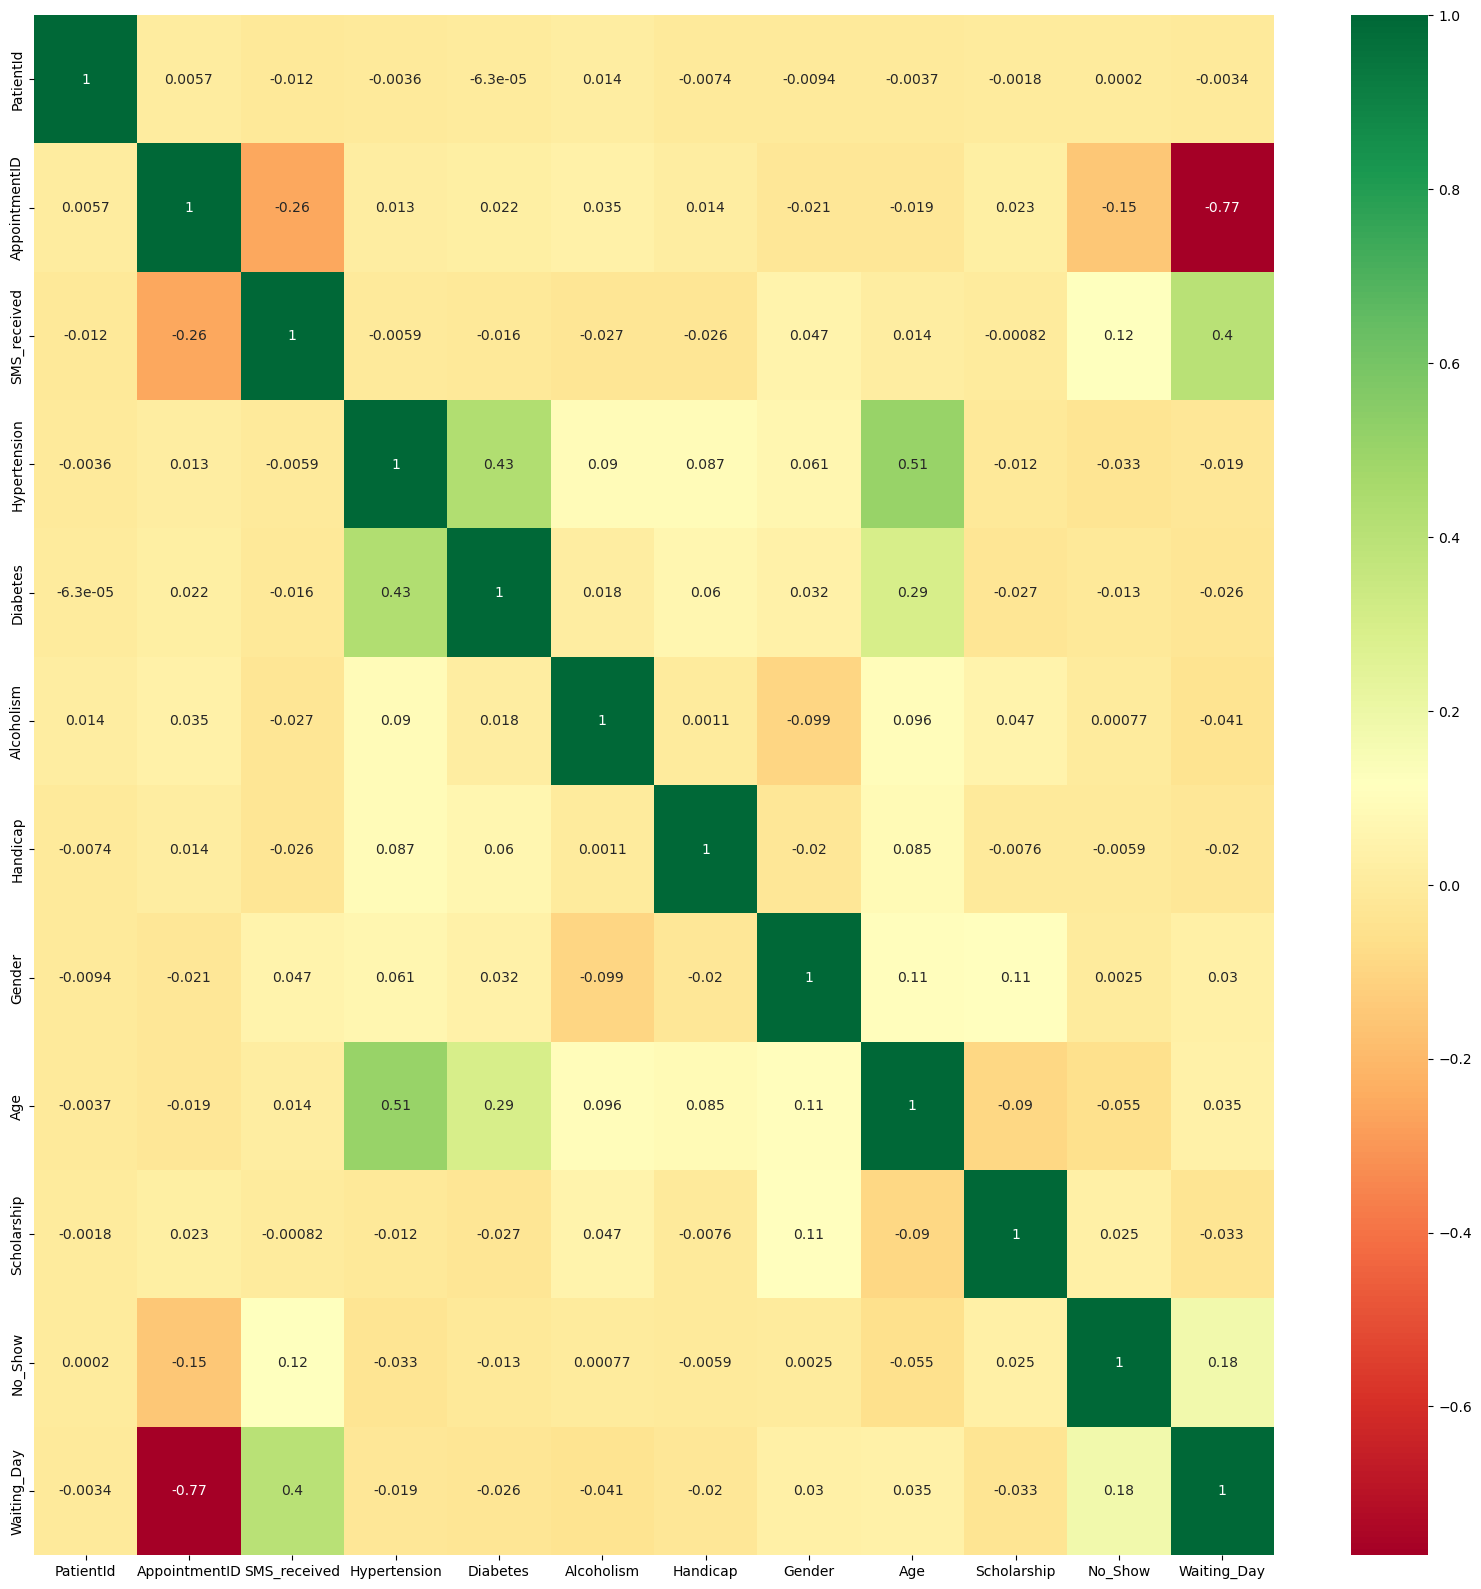

In [34]:
# Get correlation of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))
# Plotting heat map
hm = sns.heatmap(df[top_corr_features].corr(), annot = True, cmap = 'RdYlGn')

In [ ]:
# Creating dummies
dum = df['Neighbourhood'].value_counts(normalize=True)
np.sum(dum > .02)

In [ ]:
## So only 18 dummies as per above logic
df_dum = dum[dum > .02].index ## these are the ones which we should use as dummies
df = df.assign(**{
                "new_nhood": np.where(df.Neighbourhood.isin(df_dum), df.Neighbourhood, 'Other') 
                 }).drop('Neighbourhood', axis=1)

In [ ]:
# concat to df and the drop unwanted column
df = pd.concat([df, pd.get_dummies(df.new_nhood, drop_first = True)],axis=1)
df.drop(['new_nhood'],axis=1,inplace=True)

In [ ]:
# split the data into train and test as previous
train_df =df[df['Data'] =='train']
test_df = df[df['Data'] =='test']

In [ ]:
# Drop unwanted columns
train_df.drop('Data',axis=1,inplace=True)
test_df.drop('Data',axis=1,inplace=True)
test_df.drop('No_Show',axis=1,inplace=True)

In [ ]:
test_df.columns

In [ ]:
train_df.shape, test_df.shape

In [ ]:
# check if header's are consistent in both train and test
set(train_df.columns) - set(test_df.columns)

In [ ]:
# Split the train dataset into features and target variable
X = train_df.drop('No_Show', axis=1)
y = train_df['No_Show']

In [ ]:
# Standardising the data
scaler = StandardScaler()
train = scaler.fit_transform(X)
# here we just need to standardise the train data, no need to do this on target

In [ ]:
# checking event rate
y.value_counts()

In [ ]:
# Balancing the data
ros = RandomOverSampler(random_state=2)
X_resample,y_resample = ros.fit_resample(X,y)
from collections import Counter
print(sorted(Counter(y_resample).items()),y_resample.shape)

In [ ]:
# Split the train dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=5)

### XGBoost

In [ ]:
# Train the model
xgb = XGBClassifier()

In [ ]:
# fitting the model
xgb.fit(X_train,y_train)

In [ ]:
# Predict the target variable for the validation set
y_pred = xgb.predict(X_test)

In [ ]:
# Calculate the roc_auc score for the validation set
score = roc_auc_score(y_test, y_pred)

print("roc_auc score: ", score)

In [ ]:
# Predict the target variable for the test set
test_pred = xgb.predict(test_df)

In [ ]:
# Create a submission file with the predicted probabilities
submission_df = pd.DataFrame({'PatientId': test_df['PatientId'], 'No_Show': test_pred})
submission_df.to_csv('No_Shows_for_Medical_Appointments_08.csv', index=False)

### Decision Tree

In [ ]:
# Train the model
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=5, min_samples_leaf=5)

In [ ]:
# fitting the model
clf_entropy.fit(X_train, y_train)

In [ ]:
# Predict the target variable for the validation set
y_pred_en = clf_entropy.predict(X_test)

In [ ]:
# Calculate the roc_auc score for the validation set
score_en = roc_auc_score(y_test, y_pred_en)

print("roc_auc score: ", score_en)